**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [223]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import string
from multiprocessing import Pool
from functools import partial

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier, KDTree
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [254]:
%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute', leaf_size=40, metric='euclid'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.leaf_size = leaf_size
        self.metric = metric

    def fit(self, X, y):
        self.n_classes = np.unique(y).shape[0]
        self.target = y
        
        if self.algorithm == 'brute':
            self.X_train = X
            
        elif self.algorithm == 'kd_tree':
            self.X_train = X
            self.tree = KDTree(X, leaf_size=self.leaf_size)
        
        return self

    def _predict(self, X):
        # найдем матрицу расстояний
        d = self.dist(X)

        # вернем индексы k ближ соседей в обучающей выборке
        # для каждого объекта из теста
        ind = np.argpartition(d, self.n_neighbors,
                              axis=1)[:, :self.n_neighbors]

        # извлечем метки соседей
        nei_labels = self.target[ind]

        return nei_labels
    
    def predict(self, X):
        if self.algorithm == 'brute':
            nei_labels = self._predict(X)

        elif self.algorithm == 'kd_tree':
            ind = self.tree.query(X, k=self.n_neighbors, return_distance=False)
            nei_labels = self.target[ind]
        
        return np.apply_along_axis(lambda x: np.argmax(np.bincount(x)),
                                   1, nei_labels)

    def _class_counts(self, x):
        counts = np.zeros(self.n_classes)
        for k in range(self.n_classes):
            counts[k] = np.where(x == k)[0].shape[0]
        return counts / self.n_neighbors
    
    def predict_proba(self, X):
        # Оценка вероятности принадлежности :
        # к классу K
        # число соседей с классом K / число соседей
        
        if self.algorithm == 'brute':
            nei_labels = self._predict(X)

        elif self.algorithm == 'kd_tree':
            _, ind = self.tree.query(X, k=self.n_neighbors)
            nei_labels = self.target[ind]

        y_proba = np.apply_along_axis(self._class_counts, 1, nei_labels)
        return y_proba

    def score(self, X, y):
        # посчитаем accuracy т.е.
        # число верных предсказаний / общее число предсказаний
        y_pred = self.predict(X)
        return np.sum(y_pred == y) / y.shape[0]

    def dist(self, X_test):
        if self.metric == 'euclid':
            # Матрица евклидовых расстояний (стандартная метрика в sklearn)
            # от кажд точки X_test до каждой точки self.X_train
            return np.sqrt(np.sum(X_test**2, axis=1)[:, np.newaxis] -
                           2*(X_test @ self.X_train.T) +
                           np.sum(self.X_train**2, axis=1))
        elif self.metric == 'cosine':
            # ставим минус, ибо чем меньше косинусное расстояние,
            # тем объект "дальше" (менее похож)
            return -cosine_similarity(X_test, self.X_train)

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [113]:
iris = datasets.load_iris()

In [114]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [115]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [116]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

MyKNeighborsClassifier(algorithm='brute', leaf_size=40, metric='euclid',
                       n_neighbors=2)

In [117]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [118]:
%time clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 456 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [119]:
%time my_clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 115 µs


MyKNeighborsClassifier(algorithm='brute', leaf_size=40, metric='euclid',
                       n_neighbors=2)

In [120]:
%time clf.predict(X_test)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.84 ms


array([0, 1, 0, 1, 0, 2, 1, 2, 1, 2, 0, 2, 2, 0, 2])

In [121]:
%time my_clf.predict(X_test)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 667 µs


array([0, 1, 0, 1, 0, 2, 1, 2, 1, 2, 0, 2, 2, 0, 2])

In [122]:
%time clf.predict_proba(X_test)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 824 µs


array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [123]:
%time my_clf.predict_proba(X_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 861 µs


array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [124]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [125]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [126]:
%time clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 683 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [127]:
%time my_clf.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 299 µs


MyKNeighborsClassifier(algorithm='kd_tree', leaf_size=40, metric='euclid',
                       n_neighbors=2)

In [128]:
%time clf.predict(X_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.9 ms


array([0, 0, 1, 2, 2, 2, 1, 2, 1, 0, 0, 0, 1, 1, 2])

In [129]:
%time my_clf.predict(X_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 578 µs


array([0, 0, 1, 2, 2, 2, 1, 2, 1, 0, 0, 0, 1, 1, 2])

In [130]:
%time clf.predict_proba(X_test)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 801 µs


array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [131]:
%time my_clf.predict_proba(X_test)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.14 ms


array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [132]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [133]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [134]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [135]:
# data_tok should be a list of lists of tokens for each line in data.
def tokenize_text(data, target):
    p2s = str.maketrans(string.punctuation+string.digits, " "*len(string.punctuation+string.digits))
    filter_char = lambda s: "".join([c if 'a' <= c <= 'z' else ' ' for c in s])
    data_tok = [filter_char(s.lower()).split() for s in data]
    
    target_ = []
    data_tok_ = []
    for i, s in enumerate(data_tok):
        if len(s) > 0:
            target_.append(target[i])
            data_tok_.append(s)

    target_ = np.array(target_).astype(np.int32)
    
    return data_tok_, target_

In [136]:
data_tok, target = tokenize_text(data, target)

In [137]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [138]:
# используем CountVectorizer
# ограничимся термами, которые встречаются хотя бы 10 раз (т.е. в ~0,5% текстов)
count_vect = CountVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, min_df=50)
news_train = count_vect.fit_transform(data_tok)
news_train

<11004x2905 sparse matrix of type '<class 'numpy.int64'>'
	with 799360 stored elements in Compressed Sparse Row format>

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [139]:
folds = StratifiedKFold(n_splits=3, random_state=2019)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [209]:
# функция для оценки accuracy для
# фикс. числа соседей по кросс-валидации
def score_k(k, X_train, target, folds, metric='euclid'):
    
    res = []    
    print(f'Number of neighbors: {k}')
    for n, (tr_ind, val_ind) in enumerate(folds.split(X_train, target)):
        model = MyKNeighborsClassifier(n_neighbors=k, algorithm='brute', metric=metric)
        model.fit(X_train[tr_ind].toarray(), target[tr_ind])
        res.append(model.score(X_train[val_ind].toarray(), target[val_ind]))

    res.append(np.mean(res))
    
    return {k: res}

In [210]:
# функция для параллельного поиска опт. числа соседей
def grid_k(X_train, target, folds, params, metric='euclid'):
    
    partial_score_euclid = partial(score_k, 
                               X_train=X_train, 
                               target=target, 
                               folds=folds,
                               metric=metric
                              )
    grid_res = {}
    with Pool(10) as p:
        for r in p.map(partial_score_euclid, params):
            grid_res.update(r)
            
    return grid_res

In [161]:
%%time
params = list(range(1,11))
euclid_count_res = grid_k(news_train, target, folds, params, metric='euclid')

Number of neighbors: 1
Number of neighbors: 2
Number of neighbors: 3
Number of neighbors: 4
Number of neighbors: 5
Number of neighbors: 6
Number of neighbors: 7
Number of neighbors: 8
Number of neighbors: 9
Number of neighbors: 10
CPU times: user 668 ms, sys: 292 ms, total: 960 ms
Wall time: 7min 20s


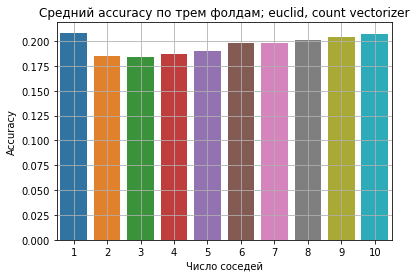

In [238]:
sns.barplot(params, [euclid_count_res[k][-1] for k in params])
plt.title('Средний accuracy по трем фолдам; euclid, count vectorizer')
plt.xlabel('Число соседей')
plt.ylabel('Accuracy')
plt.grid()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

In [162]:
%%time
params = list(range(1,11))
cosine_count_res = grid_k(news_train, target, folds, params, metric='cosine')

Number of neighbors: 1
Number of neighbors: 2
Number of neighbors: 3
Number of neighbors: 4
Number of neighbors: 5
Number of neighbors: 6
Number of neighbors: 7
Number of neighbors: 8
Number of neighbors: 9
Number of neighbors: 10
CPU times: user 132 ms, sys: 132 ms, total: 264 ms
Wall time: 37.5 s


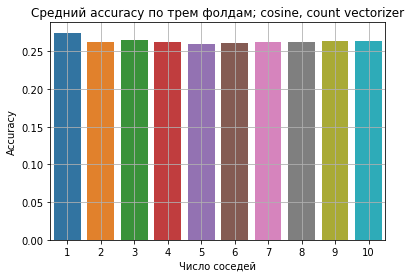

In [237]:
sns.barplot(params, [cosine_count_res[k][-1] for k in params])
plt.title('Средний accuracy по трем фолдам; cosine, count vectorizer')
plt.xlabel('Число соседей')
plt.ylabel('Accuracy')
plt.grid()

Теперь используем TfIdfVectorizer

In [249]:
tfidf = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, min_df=50)
news_train_tfidf = tfidf.fit_transform(data_tok)
news_train_tfidf.shape

(11004, 2905)

In [224]:
%%time
params = list(range(1,11))
euclid_tfidf_res = grid_k(news_train_tfidf, target, folds, params, metric='euclid')

Number of neighbors: 1
Number of neighbors: 2
Number of neighbors: 3
Number of neighbors: 4
Number of neighbors: 5
Number of neighbors: 6
Number of neighbors: 7
Number of neighbors: 8
Number of neighbors: 9
Number of neighbors: 10
CPU times: user 100 ms, sys: 160 ms, total: 260 ms
Wall time: 38.7 s


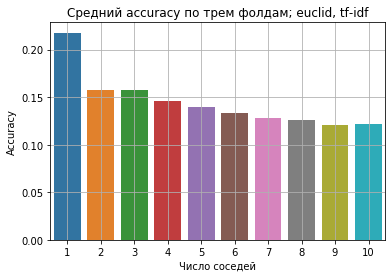

In [236]:
sns.barplot(params, [euclid_tfidf_res[k][-1] for k in params])
plt.title('Средний accuracy по трем фолдам; euclid, tf-idf')
plt.xlabel('Число соседей')
plt.ylabel('Accuracy')
plt.grid()

In [212]:
%%time
params = list(range(1,11))
cosine_tfidf_res = grid_k(news_train_tfidf, target, folds, params, metric='cosine')

Number of neighbors: 1
Number of neighbors: 2
Number of neighbors: 3
Number of neighbors: 4
Number of neighbors: 5
Number of neighbors: 6
Number of neighbors: 7
Number of neighbors: 8
Number of neighbors: 9
Number of neighbors: 10
CPU times: user 96 ms, sys: 156 ms, total: 252 ms
Wall time: 38.4 s


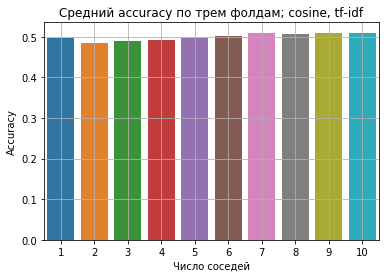

In [235]:
sns.barplot(params, [cosine_tfidf_res[k][-1] for k in params])
plt.title('Средний accuracy по трем фолдам; cosine, tf-idf')
plt.xlabel('Число соседей')
plt.ylabel('Accuracy')
plt.grid()

**Соберем общую таблицу**

In [226]:
res_table = pd.DataFrame(index=params)
res_table['euclid_count_mean_acc'] = [euclid_count_res[k][-1] for k in params]
res_table['cosine_count_mean_acc'] = [cosine_count_res[k][-1] for k in params]
res_table['euclid_tfidf_mean_acc'] = [euclid_tfidf_res[k][-1] for k in params]
res_table['cosine_tfidf_mean_acc'] = [cosine_tfidf_res[k][-1] for k in params]

In [227]:
res_table.max()

euclid_count_mean_acc    0.208284
cosine_count_mean_acc    0.274621
euclid_tfidf_mean_acc    0.217732
cosine_tfidf_mean_acc    0.510081
dtype: float64

In [229]:
res_table.cosine_tfidf_mean_acc.idxmax()

9

**Лучшая модель**: число соседей = 9, метрика = косинусное расстояние, векторизация = tf-idf

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [250]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
test_data = newsgroups['data']
test_target = newsgroups['target']

In [251]:
test_data, test_target = tokenize_text(test_data, test_target)
news_test = tfidf.transform(test_data)
news_test

<7307x2905 sparse matrix of type '<class 'numpy.float64'>'
	with 516008 stored elements in Compressed Sparse Row format>

In [253]:
model = MyKNeighborsClassifier(n_neighbors=9, algorithm='brute', metric='cosine')
model.fit(news_train_tfidf, target)
model.score(news_test, test_target)

0.4655809497741891

Видим, что качество на тесте чуть меньше, чем на трейне (0.47 против 0.51). Падение качества связано с тем, что в тесте присутствуют слова, которые не присутствуют в трейне - при векторизации счетчики таких слов обнуляются, поэтому в расчет расстояния до объектов обучающей выборки вносятся искажения.